# Machine learning for free energy functional for 1D Lennard Jones fluid
## -Examing part

In [1]:
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from numba import jit

from matplotlib import rc
rc('text', usetex=True)

In [2]:
file_dir = "_fuzzy"

In [3]:
f = open('LJ_data'+file_dir+'/MC_parameter.dat', 'r')
temp = f.read().split("\t")
L=float(temp[0])
dx=float(temp[1])
N=int(L/dx)
batch_size = int(temp[2])
f.close()

In [4]:
f = open('./ML_data/parameter_kernel_sq.txt', 'r')
temp = f.read().splitlines()
dx=float(temp[0])
Lw=int(temp[1])
LLw = int((Lw-1)/2)
Nw=int(temp[2])
f.close()

In [5]:
print(str(dx)+"\t"+str(Lw)+"\t"+str(LLw)+"\t"+str(Nw))

0.03125	257	128	8


In [6]:
w=np.loadtxt("./ML_data/w_kernel_sq.txt")
beta = np.zeros((Nw,Nw))
beta=np.loadtxt("./ML_data/beta_kernel_sq.txt")
error = np.loadtxt("./ML_data/epco_error_sq.txt")

(array([  0.1,   1. ,  10. , 100. ]), <a list of 4 Text yticklabel objects>)

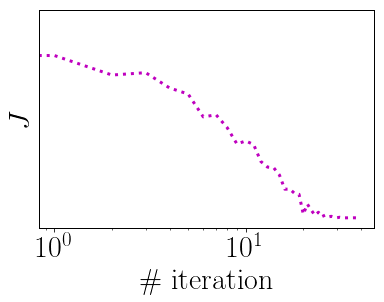

In [7]:
gold=1.618
#plt.figure(figsize=(5.5*gold,5.5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()
ax = fig.add_subplot(111)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
    
plt.loglog(error,"m:",linewidth=3)
plt.ylabel(r"$J$",size=30) 
plt.xlabel(r"$\#$ iteration",size=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


In [32]:
error[-1]

2.354390071525018

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3]),
 <a list of 7 Text yticklabel objects>)

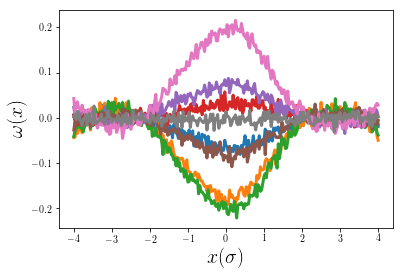

In [33]:
gold=1.618
#plt.figure(figsize=(5.5*gold,5.5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

x = np.linspace(-LLw,LLw,Lw)*dx
for j in range (Nw):
    plt.plot(x,w[j],label="$\omega$"+str(j),linewidth=3)
plt.ylabel("$\omega(x)$",size=20)
plt.xlabel("$x(\sigma$)",size=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


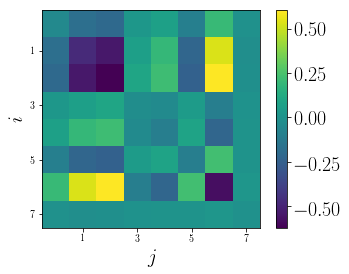

In [34]:
gold=1.618

#plt.figure(figsize=(5.5*gold,5.5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylabel(r"$i$",size=20)
plt.xlabel(r"$j$",size=20)
plt.xticks(np.arange(1,8, 2),fontsize=10)
plt.yticks(np.arange(1,8, 2),fontsize=10)

plt.imshow(beta)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)


In [35]:
np.sum((beta-beta.T)**2)

1.0317050606432633e-31

Text(0, 0.5, '$P$')

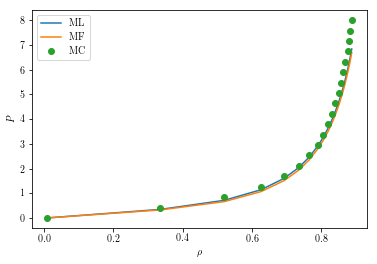

In [14]:
def cal_mu_ML(eps,beta,rho0,w):
    c1=0  
    for i in range(Nw):
        for j in range(Nw):
            c1+=eps*beta[i][j]*(np.sum(np.sum(rho0*w[i])*w[j]))*dx**2*2
    c1_FMT = rho0/(1-rho0)-np.log(1-rho0)
    #print(c1,c1_FMT)
    c1+=np.log(rho0)+c1_FMT
    return c1

def cal_f_ML(epsilon,beta,rho0,w):
    f=0  
    for i in range(Nw):
        for j in range(Nw):
            ni = np.sum(rho0*w[i])
            nj = np.sum(rho0*w[j])
            f+=(epsilon*beta[i][j])*ni*nj*dx*dx
    return f

def pressure_ML(eps,beta,rho0,w):
    mu=cal_mu_ML(eps,beta,rho0,w)
    fhr = -rho0*(np.log(1-rho0))
    fML = cal_f_ML(eps,beta,rho0,w)
    fid = rho0*(np.log(rho0)-1)
    omega = fid+fhr+fML -mu*rho0
    return -omega

def pressure_mean(eps,rho0):
    return rho0/(1-rho0)-75./55*2**(1.0/6)*eps*rho0**2

eps=1
P_MC = np.loadtxt("LJ_python_prototype/P_rho_eps_"+str(eps)+".dat")
rho0_array = np.copy(P_MC[1][np.where(P_MC[0]>0)])

P_ML = np.zeros(len(rho0_array))
P_mean = np.zeros(len(rho0_array))


for i in range (len(rho0_array)):
    P_ML[i]=pressure_ML(eps,beta,rho0_array[i],w)
    P_mean[i]=pressure_mean(eps,rho0_array[i])
    
plt.plot(rho0_array,P_ML,label="ML")
plt.plot(rho0_array,P_mean,label="MF")
plt.plot(P_MC[1][np.where(P_MC[1]>0)],P_MC[0][np.where(P_MC[1]>0)],'o',label="MC")
plt.legend()
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P$")

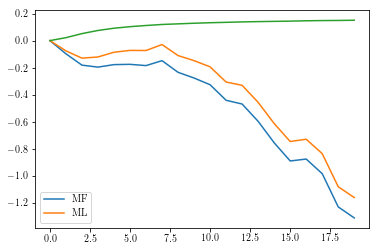

In [15]:
plt.plot(P_mean-P_MC[0],label="MF")
plt.plot(P_ML-P_MC[0],label="ML")
plt.plot(P_ML-P_mean)
plt.legend()


# Test on wall

In [14]:
@jit
def conv (rho,w):
    rho_pad=np.copy(rho)
    rho_pad=np.pad(rho_pad,(LLw,LLw),'symmetric')
    rho_pad[0:LLw]=rho_pad[N:N+LLw]
    rho_pad[N+LLw:N+LLw*2]=rho_pad[LLw:LLw+LLw]
    n = np.correlate(rho_pad,w)
    return n*dx

In [15]:
@jit
def cal_Utail_shift (Dx,epsilon):
    Dx = np.abs(Dx)
    Dx2=Dx**2
    return 4*epsilon*(1/Dx2**6-1/Dx2**3) + epsilon

@jit
def w_FMT(eps):
    R = 0.5
    k=np.linspace(0,N//2,N//2+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

@jit
def cal_n0(rho,w0):
    return np.fft.irfft(np.fft.rfft(rho)*w0)

@jit
def cal_n1(rho,w1):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

@jit
def cal_c1_FMT(rho,eps):
    w0,w1 = w_FMT(eps)
    n0=cal_n0(rho,w0)
    n1=cal_n1(rho,w1)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    return cal_n0(F0,w0)+cal_n1(F1,w1)

In [16]:
@jit
def cal_mu_ML(eps,beta,rho0,w):
    c1=0  
    for i in range(Nw):
        for j in range(Nw):
            c1+=eps*beta[i][j]*(np.sum(np.sum(rho0*w[i])*w[j]))*dx**2*2
    c1+=np.log(rho0)+cal_c1_FMT(np.full(N,rho0),eps)[0]
    return c1

In [17]:
"""add FMT terms"""
@jit
def cal_c1(beta,eps,n,w,rho):
    c1 = np.zeros((N))
    for i in range(Nw):
        for j in range(Nw):
            c1+=eps*beta[i][j]*(conv(n[i],w[j])+conv(n[j],w[i]))
    c1+=cal_c1_FMT(rho,eps)
    return c1

In [18]:
@jit
def cal_mu_FMT(rho0,eps):
    d=1.0
    R = d/2
    return (2*R*rho0)/(1 - 2*R*rho0) - np.log(1 - 2*R*rho0)

In [19]:
@jit
def cal_rho_ML(mu,c1,V):
    rho_ML = np.exp(-c1-V+mu)
    return rho_ML

In [20]:
@jit
def picard_update(rho,alpha,epsilon,mu,Vext):

    n_array = np.zeros((Nw,N))
    
    for j in range (Nw):
        n_array[j] = conv(rho,w[j])
    
    c1 = cal_c1(beta,epsilon,n_array,w,rho)
    mu_ML = mu
    rho_new = cal_rho_ML(mu_ML,c1,Vext)
    error = np.sum((rho_new-rho)**2)*dx
    rho=(1-alpha)*rho+alpha*rho_new
    return rho,error


In [21]:
z = 1.5
eps = 2

rho_ML = np.full(N,0.1)
Vext = np.zeros(N)
Vext[0:int(1/dx)]=10**8
alpha = 0.01
mu = np.log(z)

for i in range (10000):
    rho_ML,err=picard_update(rho_ML,alpha,eps,mu,Vext)
    if(i%100==0):
        print(i,err)
    if(err<10**-6):
        break;

0 119.61516171461724
100 0.13718546259137135
200 0.035962463162036065
300 0.012434989567123269
400 0.00481368140116489
500 0.0019917389543689062
600 0.0008626771495481046
700 0.000386403950250357
800 0.00017754660849664096
900 8.321716573128953e-05
1000 3.962634730546168e-05
1100 1.9113205586159016e-05
1200 9.317275571142236e-06
1300 4.582456968399445e-06
1400 2.2707238741575775e-06
1500 1.1323998402098907e-06


In [22]:
@jit
def cal_Utail (Dx,epsilon):
    Dx = np.abs(Dx)
    if Dx>L/2:
        Dx= np.abs(Dx)-L
        
    if np.abs(Dx)<=1:
        return -epsilon
    
    else:
        Dx2=Dx**2
        return 4*epsilon*(1/Dx2**6-1/Dx2**3)

@jit
def cal_Ftail_drho(rho,epsilon):
    Utail = np.zeros(N)
    for i in range (N):
        Utail[i]=cal_Utail(i*dx,epsilon)        
    Ftail = np.zeros(N)
    
    for i in range (N):
        for j in range (N):
            Ftail[i]+=Utail[np.abs(i-j)]*rho[j]*dx
    return Ftail

@jit
def cal_c1_mean(rho,epsilon):
    Ftail=cal_Ftail_drho(rho,epsilon)
    return cal_c1_FMT(rho,epsilon)+Ftail

@jit
def update_rho_mean(rho,alpha,eps,mu,Vext):
    c1 = cal_c1_mean(rho,eps)
    #mu=np.log(np.sum(np.sum(rho)/np.sum(np.exp(-c1-Vext))))
    rho_new =np.exp(mu-c1-Vext)
    rho = (1-alpha)*rho+alpha*rho_new
    err = np.sum((rho_new-rho)**2)
    return rho,err



In [23]:
rho_mean = np.full(N,0.1)
alpha = 0.01
for i in range (10000):
    rho_mean,err=update_rho_mean(rho_mean,alpha,eps,mu,Vext)
    if(i%1000==0):
        print(i,err)
    if(err<10**-6):
        break;

0 4116.71226795361
1000 0.12364942577223159
2000 0.012248877029571937
3000 0.0021353422057326533
4000 0.0004328780265837113
5000 9.21287481437122e-05
6000 2.0170582564607826e-05
7000 4.50696456638537e-06
8000 1.0219181513995702e-06


(0, 16.0)

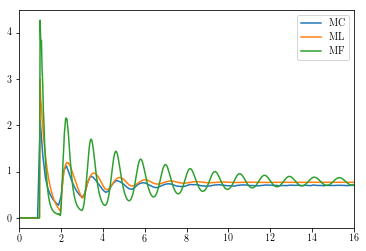

In [24]:
rho_MC = np.loadtxt("LJ_python_prototype/wall_mu_ln_"+str(z)+"_eps_"+str(eps)+"_MC.dat")
x_MC = np.linspace(0,L,len(rho_MC))
plt.plot(x_MC,rho_MC,label="MC")

x_sys = np.linspace(0,L,N)
plt.plot(x_sys,rho_ML,label="ML")
plt.plot(x_sys,rho_mean,label="MF")
plt.legend()
plt.xlim([0,L/2])